In [1]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/experiment1')
from tqdm import tqdm

## Few-Shot Dataset and Dataloader

In [2]:
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
def window_image(x, min_hu=-40, max_hu=120):
    x = np.clip(x, min_hu, max_hu)
    x = (x - min_hu) / (max_hu - min_hu)
    return x

In [4]:
def split_to_patches(img, mask):
    """Split a 512×512 image/mask into four 256×256 patches."""
    patches, masks = [], []
    # Top-left, top-right, bottom-left, bottom-right
    coords = [(0,0), (0,256), (256,0), (256,256)]
    for (i,j) in coords:
        patches.append(img[i:i+256, j:j+256].copy())
        masks.append(mask[i:i+256, j:j+256].copy())
    return patches, masks

In [5]:
class FewShotSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, shots=1):
        self.shots = shots
        self.patches = []  
        self.class_to_idxs = {}

        print("Preloading all slices... This might take a few minutes, but will save HOURS later.")

        for img_file, msk_file in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
            vol_img = nib.load(img_file).get_fdata()
            vol_msk = nib.load(msk_file).get_fdata()
            D = vol_img.shape[2]
            for z in range(D):
                slice_img = vol_img[:, :, z]
                slice_msk = vol_msk[:, :, z]
                slice_img = window_image(slice_img)
                if slice_img.shape != (512,512):
                    continue
                img_patches, msk_patches = split_to_patches(slice_img, slice_msk)
                for ip, mp in zip(img_patches, msk_patches):
                    classes = [int(c) for c in np.unique(mp) if c != 0]
                    if len(classes) == 0:
                        continue
                    self.patches.append({'image': ip, 'mask': mp, 'classes': classes})

        print(f"Total cached patches: {len(self.patches)}")

        for idx, patch in enumerate(self.patches):
            for cls in patch['classes']:
                self.class_to_idxs.setdefault(cls, []).append(idx)

        self.available_classes = list(self.class_to_idxs.keys())

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        data_q = self.patches[idx]
        # Randomly pick one class from the query patch as the target
        target_cls = np.random.choice(data_q['classes'])
        query_img = data_q['image']
        query_mask = (data_q['mask'] == target_cls).astype(np.float32)
        # Get K support indices for that class (exclude query itself)
        support_idxs = list(self.class_to_idxs[target_cls])
        if idx in support_idxs:
            support_idxs.remove(idx)
        if len(support_idxs) == 0:
            support_idxs = list(self.class_to_idxs[target_cls])  # allow reuse
        if self.shots <= len(support_idxs):
            chosen = np.random.choice(support_idxs, self.shots, replace=False)
        else:
            chosen = np.random.choice(support_idxs, self.shots, replace=True)
        support_imgs, support_msks = [], []
        for s in chosen:
            data_s = self.patches[s]
            support_imgs.append(data_s['image'])
            support_msks.append((data_s['mask'] == target_cls).astype(np.float32))
        # Convert to torch tensors with channel dim
        support_imgs = torch.from_numpy(np.stack(support_imgs)).unsqueeze(1).float()
        support_msks = torch.from_numpy(np.stack(support_msks)).unsqueeze(1).float()
        query_img   = torch.from_numpy(query_img).unsqueeze(0).float()
        query_mask  = torch.from_numpy(query_mask).unsqueeze(0).float()
        return support_imgs, support_msks, query_img, query_mask

In [6]:
from pathlib import Path
import random
class FastPatchDataset(Dataset):
    def __init__(self, patch_folder, shots=1):
        self.img_dir = Path(patch_folder) / 'images'
        self.mask_dir = Path(patch_folder) / 'masks'
        self.img_paths = sorted(self.img_dir.glob("*.pt"))
        self.mask_paths = sorted(self.mask_dir.glob("*.pt"))
        self.shots = shots

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        query_img = torch.load(self.img_paths[idx]).float()
        query_mask = torch.load(self.mask_paths[idx]).float()
        if query_mask.ndim == 2:
            query_mask = query_mask.unsqueeze(0)
        query_mask = (query_mask > 0).float()  # Binarize here ✅


        # Ensure shape: (1, 256, 256)
        if query_img.ndim == 2:
            query_img = query_img.unsqueeze(0)
        if query_mask.ndim == 2:
            query_mask = query_mask.unsqueeze(0)

        # Sample support indices
        support_idxs = list(range(0, idx)) + list(range(idx + 1, len(self.img_paths)))
        support_idxs = random.sample(support_idxs, self.shots)

        support_imgs, support_msks = [], []

        for s_idx in support_idxs:
            s_img = torch.load(self.img_paths[s_idx]).float()
            s_msk = torch.load(self.mask_paths[s_idx]).float()

            if s_img.ndim == 2:
                s_img = s_img.unsqueeze(0)
            elif s_img.ndim == 3 and s_img.shape[0] == 1:
                pass  # already correct
            else:
                raise ValueError(f"Bad shape: {s_img.shape}")
            if s_msk.ndim == 2:
                s_msk = s_msk.unsqueeze(0)
            s_msk = (s_msk > 0).float()  # Binarize here too ✅

            support_imgs.append(s_img)
            support_msks.append(s_msk)

        # Stack to (K, 1, 256, 256)
        #print("Support indiv shape:", s_img.shape)

        support_imgs = torch.stack(support_imgs)
        support_msks = torch.stack(support_msks)

        return support_imgs.squeeze(0), support_msks.squeeze(0), query_img, query_mask


In [7]:
# Example: Get list of your BHSD labeled image paths
import glob

image_paths = sorted(glob.glob('BHSD/label_192/images/*.nii.gz'))
mask_paths  = sorted(glob.glob('BHSD/label_192/ground truths/*.nii.gz'))

In [8]:
# Split into 70% train, 10% val, 20% test (as paper suggests)
from sklearn.model_selection import train_test_split

train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=42)

val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=2/3, random_state=42)

In [9]:
# Now create your datasets
train_dataset = FastPatchDataset('BHSD/preprocessed_patches', shots=1)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
val_dataset   = FewShotSegDataset(val_imgs, val_masks, shots=1)
test_dataset  = FewShotSegDataset(test_imgs, test_masks, shots=1)

Preloading all slices... This might take a few minutes, but will save HOURS later.


100%|██████████| 19/19 [00:07<00:00,  2.58it/s]


Total cached patches: 618
Preloading all slices... This might take a few minutes, but will save HOURS later.


100%|██████████| 39/39 [00:14<00:00,  2.62it/s]

Total cached patches: 897


## CGNet Architecture

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

Cross-Feature Module (CFM):
This module fuses support and query features to highlight lesion correlations.

In [11]:
class CrossFeatureModule(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.conv_q = nn.Conv2d(in_ch, in_ch, 3, padding=1)
        self.conv_s = nn.Conv2d(in_ch, in_ch, 3, padding=1)
        self.conv_out = nn.Conv2d(in_ch * 2, in_ch, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, Fq, Fs):
        Q = self.relu(self.conv_q(Fq))
        S = self.relu(self.conv_s(Fs))
        M = Q * S
        out = self.conv_out(torch.cat([Fq, M], dim=1))
        return self.relu(out)

 Support Guide Query (SGQ): In CGNet, the SGQ refines segmentation by integrating support and query at multiple scales. In practice, one might propagate the fused features (CFM output) along a feature pyramid. For simplicity, we note SGQ as concept and continue with a pyramid decoder that implicitly uses multi-scale information.

Multi Scale Pyramid Decoder: We decode the fused feature map back to full resolution using upsampling and skip connections. 

In [12]:
class MultiScaleDecoder(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.up1 = nn.ConvTranspose2d(in_ch, 512, 2, stride=2)
        self.conv1 = nn.Conv2d(512, 512, 3, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = nn.Conv2d(256, 256, 3, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(self.up1(x)))  # 8 -> 16
        x = F.relu(self.conv2(self.up2(x)))  # 16 -> 32
        x = F.relu(self.conv3(self.up3(x)))  # 32 -> 64
        x = F.relu(self.conv4(self.up4(x)))  # 64 -> 128
        return x

Iteration Decoder: Iterativley refines the output

In [13]:
class IterationDecoder(nn.Module):
    def __init__(self, feat_ch):
        super().__init__()
        self.final_conv = nn.Conv2d(feat_ch, 1, kernel_size=1)

    def forward(self, feat):
        logit1 = self.final_conv(feat)
        pred1 = torch.sigmoid(logit1)

        attn = F.interpolate(pred1, size=feat.shape[2:], mode='bilinear', align_corners=False)
        feat2 = feat * attn
        logit2 = self.final_conv(feat2)
        out = torch.sigmoid(logit2)

        # Force output to 256x256
        out = F.interpolate(out, size=(256, 256), mode='bilinear', align_corners=False)
        return out

In [14]:
class CGNet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet18(pretrained=True)  # ⬅️ using ResNet-18 for speed

        # Modify first conv for 1-channel input
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        resnet.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)

        self.encoder = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
        )

        self.cfm = CrossFeatureModule(in_ch=512)  # 512 for ResNet-18
        self.decoder = MultiScaleDecoder(in_ch=512)
        self.iter_decoder = IterationDecoder(feat_ch=64)

    def forward(self, support_imgs, support_msks, query_img):
        # support_imgs: (1, shots, 1, 256, 256)
        # query_img: (1,1,256,256)

        shots = support_imgs.size(1)

        # Flatten support batch
        support_imgs_batch = support_imgs.view(shots, 1, 256, 256)
        support_msks_batch = support_msks.view(shots, 1, 256, 256)

        # Encode all supports at once
        feat_s_batch = self.encoder(support_imgs_batch)  # (shots, C, H', W')
        masks_resized = F.interpolate(support_msks_batch, size=feat_s_batch.shape[2:], mode='bilinear', align_corners=False)
        feat_s_batch = feat_s_batch * masks_resized

        # Mean of all support features
        support_feat = torch.mean(feat_s_batch, dim=0, keepdim=True)  # (1, C, H', W')

        # Encode query
        query_img = query_img  # (1,1,256,256)
        feat_q = self.encoder(query_img)

        # Cross-feature interaction
        fused = self.cfm(feat_q, support_feat)

        # Decode
        dec_feat = self.decoder(fused)

        # Iterative prediction
        out_mask = self.iter_decoder(dec_feat)

        return out_mask

## Training

In [15]:
'''import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"'''

'import os\nos.environ["CUDA_LAUNCH_BLOCKING"] = "1"'

In [16]:
import torch

# Check if GPU is available, else fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


In [17]:
# Global Training Settings
num_epochs = 50
batch_size = 1
learning_rate = 1e-4
shots = 1
ways = 1

train_losses, val_losses = [], []
train_dices, val_dices = [], []
train_ious, val_ious = [], []

best_val_loss = float('inf')

In [18]:
model = CGNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_loader = DataLoader(
    train_dataset, 
    batch_size, 
    shuffle=True, 
    num_workers=0, 
    pin_memory=False
)
val_loader = DataLoader(
    val_dataset, 
    batch_size, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=False
)

c:\ETC\py\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ETC\py\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluation parameters

In [19]:
def iou_score(pred, target, eps=1e-6):
    pred_bin = (pred > 0.5).float()
    target_bin = (target > 0.5).float()
    inter = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum() - inter
    return (inter + eps) / (union + eps)

In [20]:
def dice_score(pred, target, eps=1e-6):
    pred_bin = (pred > 0.5).float()
    target_bin = (target > 0.5).float()
    inter = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum()
    return (2 * inter + eps) / (union + eps)

In [24]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    epoch_dices = []
    epoch_ious = []

    for i, (support_imgs, support_msks, query_img, query_mask) in enumerate(train_loader):
        print(f"→ Batch {i+1}/{len(train_loader)} loaded")
        def safe_to_device(x, device):
            if not torch.isfinite(x).all():
                raise ValueError("Tensor contains NaN or Inf")
            return x.to(device)

        support_imgs = safe_to_device(support_imgs.float(), device)
        support_msks = safe_to_device(support_msks.float(), device)
        query_img    = safe_to_device(query_img.float(), device)
        query_mask   = safe_to_device(query_mask.float(), device)

        optimizer.zero_grad()
        pred = model(support_imgs, support_msks, query_img)
        pred = pred.float()

        query_mask = (query_mask > 0.5).float()
        if query_mask.shape != pred.shape:
            query_mask = F.interpolate(query_mask, size=pred.shape[2:], mode='bilinear', align_corners=False)


        loss_bce = F.binary_cross_entropy(pred, query_mask)
        loss_dice_val = dice_score(pred, query_mask)
        loss = loss_bce + (1 - loss_dice_val)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_dices.append(loss_dice_val.item())
        epoch_ious.append(iou_score(pred, query_mask).item())

    # === End of training epoch ===
    avg_train_loss = running_loss / len(train_loader)
    avg_train_dice = sum(epoch_dices) / len(epoch_dices)
    avg_train_iou = sum(epoch_ious) / len(epoch_ious)

    train_losses.append(avg_train_loss)
    train_dices.append(avg_train_dice)
    train_ious.append(avg_train_iou)

    # === Validation ===
    model.eval()
    val_running_loss = 0.0
    val_dice_scores = []
    val_iou_scores = []

    with torch.no_grad():
        for support_imgs, support_msks, query_img, query_mask in val_loader:
            support_imgs = support_imgs.to(device).float()
            support_msks = support_msks.to(device).float()
            query_img    = query_img.to(device).float()
            query_mask   = query_mask.to(device).float()

            pred = model(support_imgs, support_msks, query_img)
            pred = pred.float()
            query_mask = (query_mask > 0.5).float()

            if query_mask.shape != pred.shape:
                query_mask = F.interpolate(query_mask, size=pred.shape[2:], mode='bilinear', align_corners=False)

            loss_bce = F.binary_cross_entropy(pred, query_mask)
            loss_dice_val = dice_score(pred, query_mask)
            val_loss = loss_bce + (1 - loss_dice_val)

            val_running_loss += val_loss.item()
            val_dice_scores.append(loss_dice_val.item())
            val_iou_scores.append(iou_score(pred, query_mask).item())

    avg_val_loss = val_running_loss / len(val_loader)
    avg_val_dice = sum(val_dice_scores) / len(val_dice_scores)
    avg_val_iou = sum(val_iou_scores) / len(val_iou_scores)

    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)
    val_ious.append(avg_val_iou)

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss={avg_train_loss:.4f}, Dice={avg_train_dice:.4f}, IoU={avg_train_iou:.4f}")
    print(f"  Val   Loss={avg_val_loss:.4f}, Dice={avg_val_dice:.4f}, IoU={avg_val_iou:.4f}")


  0%|          | 0/50 [00:00<?, ?it/s]

→ Batch 1/4851 loaded
→ Batch 2/4851 loaded
→ Batch 3/4851 loaded
→ Batch 4/4851 loaded
→ Batch 5/4851 loaded
→ Batch 6/4851 loaded
→ Batch 7/4851 loaded
→ Batch 8/4851 loaded
→ Batch 9/4851 loaded
→ Batch 10/4851 loaded
→ Batch 11/4851 loaded
→ Batch 12/4851 loaded
→ Batch 13/4851 loaded
→ Batch 14/4851 loaded
→ Batch 15/4851 loaded
→ Batch 16/4851 loaded
→ Batch 17/4851 loaded
→ Batch 18/4851 loaded
→ Batch 19/4851 loaded
→ Batch 20/4851 loaded
→ Batch 21/4851 loaded
→ Batch 22/4851 loaded
→ Batch 23/4851 loaded
→ Batch 24/4851 loaded
→ Batch 25/4851 loaded
→ Batch 26/4851 loaded
→ Batch 27/4851 loaded
→ Batch 28/4851 loaded
→ Batch 29/4851 loaded
→ Batch 30/4851 loaded
→ Batch 31/4851 loaded
→ Batch 32/4851 loaded
→ Batch 33/4851 loaded
→ Batch 34/4851 loaded


  0%|          | 0/50 [00:03<?, ?it/s]

→ Batch 35/4851 loaded


KeyboardInterrupt: 

In [ ]:
print(f'dice={avg_train_dice}, iou = {avg_train_iou}, loss = {avg_train_loss}')

dice=0.8515958667829854, iou = 0.7692254341651248, loss = 0.15371554100629112


In [ ]:
# save model
torch.save(model.state_dict(), f"checkpoints/85_cgnet_checkpoint_2.pth")

# how to load later
'''
model = CGNet()
model.load_state_dict(torch.load("checkpoints/dice_cgnet_checkpoint_1.pth"))
model.to(device)
model.eval()  # Set to inference mode
'''

'\nmodel = CGNet()\nmodel.load_state_dict(torch.load("checkpoints/dice_cgnet_checkpoint_1.pth"))\nmodel.to(device)\nmodel.eval()  # Set to inference mode\n'

## Visualization

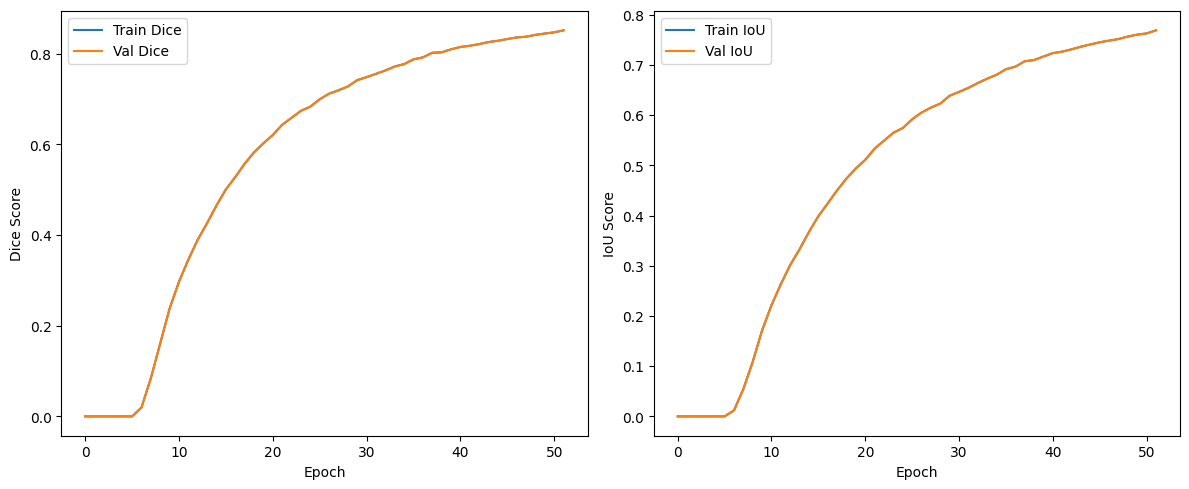

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Val Dice')
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.xlabel("Epoch")
plt.ylabel("IoU Score")
plt.legend()

plt.tight_layout()
plt.show()

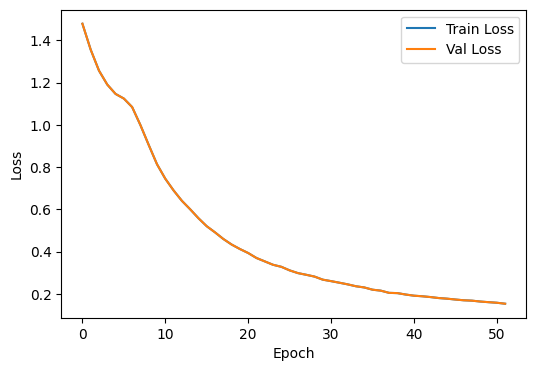

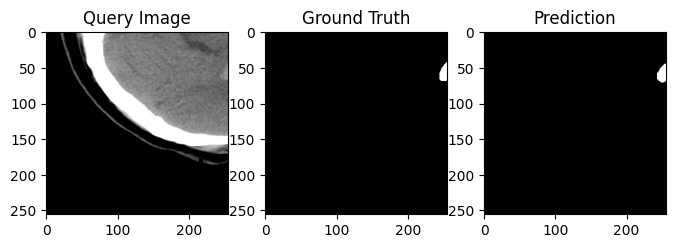

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.show()

# Show example segmentation
model.eval()
with torch.no_grad():
    sup_imgs, sup_msks, q_img, q_mask = next(iter(val_loader))
    pred = model(sup_imgs.to(device), sup_msks.to(device), q_img.to(device))
    pred_np = pred.cpu().squeeze().numpy()
    q_img_np = q_img.squeeze().numpy()
    q_mask_np = q_mask.squeeze().numpy()
plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.title("Query Image"); plt.imshow(q_img_np, cmap='gray')
plt.subplot(1,3,2)
plt.title("Ground Truth"); plt.imshow(q_mask_np, cmap='gray')
plt.subplot(1,3,3)
plt.title("Prediction");   plt.imshow(pred_np>0.5, cmap='gray')
plt.show()